In [1]:
import os
import glob
import re
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.utils import normalize

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Preprocessing

In [2]:
# resizes images to desired dimensions
def resize(img, height=256, width=256):
    return cv2.resize(img, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

In [3]:
def get_image_names(jsrt_path='Downloads'):
    # path to raw images
    home = os.path.expanduser('~')
    image_dir = os.path.join(home, jsrt_path, 'jsrt/images/images')
    
    # get image names
    image_names =  os.listdir(image_dir)
    image_names.sort()
    
    return image_names

In [4]:
def get_images(jsrt_path='Downloads', height=256, width=256, original_size=False):
    if original_size:
        height = 1024
        width = 1024
    
    home = os.path.expanduser('~')
    image_dir = os.path.join(home, jsrt_path, 'jsrt/images/images')
    
    # load image names
    image_names = get_image_names()
    
    # create numpy array to hold image arrays
    images = np.zeros((len(image_names), height, width, 3))
    
    # load iamges
    for i in range(len(image_names)):
        img_path = os.path.join(image_dir, image_names[i])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        # resize
        img = resize(img, height, width)
        #img = np.expand_dims(img, axis=2)
        
        # normalize
        img = img / 255
        
        images[i] = img
    
    return images

In [5]:
# groups all masks belonging to same image into multi-channel array
def get_masks(jsrt_path='Downloads', scr_path='Downloads', height=256, width=256, original_size=False):
    if original_size:
        height = 1024
        width = 1024
        
    regions = ['heart', 'left clavicle', 'right clavicle', 'left lung', 'right lung']
    
    home = os.path.expanduser('~')
    
    # get all unique image names
    image_names = get_image_names()
    
    # convert '.png' to '.gif' extension to match masks' name
    mask_names = [re.sub(r'.png','.gif', i) for i in image_names]
    
    # odd and even numbered masks are separated into separate directories
    fold1 = os.path.join(home, scr_path, 'scr/scratch/fold1/masks')
    fold2 = os.path.join(home, scr_path, 'scr/scratch/fold2/masks')
    
    # create numpy array to hold multi-channel masks
    masks = np.zeros((len(mask_names), height, width, len(regions)))
    
    # group individual image masks into single array
    for i in range(len(mask_names)):
        masks_ = []
        
        for region in regions:
            fold1_region = os.path.join(fold1, region)
            fold2_region = os.path.join(fold2, region)
            
            fold1_region_names = os.listdir(os.path.join(fold1, region))
            fold2_region_names = os.listdir(os.path.join(fold2, region))
            
            if mask_names[i] in fold1_region_names:
                img_ = plt.imread(os.path.join(fold1_region, mask_names[i]))
                # resize 
                img = resize(img_, height, width)
            else:
                img_ = plt.imread(os.path.join(fold2_region, mask_names[i]))
                # resize
                img = resize(img_, height, width)
            
            masks_.append(img)
            
        img_masks = np.stack(masks_, axis=-1)
        
        masks[i] = img_masks
        
        # binarize the masks
        masks_bin = np.where(masks==255, masks, 0)
        masks_bin = np.where(masks==0, masks, 1)
        masks_bin = masks_bin.astype('float64')
    
    return masks_bin

In [6]:
def save_image_names(image_names, dir_path=os.path.join(os.path.expanduser('~'), 'Downloads/data')):
    # directory to save image names
    try:
        os.mkdir(dir_path)
    except:
        pass
    # save image names
    f = open(os.path.join(dir_path, 'image_names.pickle'), 'wb')
    pickle.dump(image_names, f)

In [7]:
# saves grouped image masks (numpy array) as pickle along with image names
def save_masks(masks, dir_path=os.path.join(os.path.expanduser('~'),'Downloads/data')):
    # create directory to save masks
    try:
        os.mkdir(dir_path)
    except:
        pass
    
    # save masks
    f = open(os.path.join(dir_path, 'masks.pickle'), 'wb')
    pickle.dump(masks, f)

In [8]:
# loads list of image names
def load_image_names(image_pickle='image_names.pickle', dir_path=os.path.join(os.path.expanduser('~'), 'Downloads/data')):
    f = open(os.path.join(dir_path, image_pickle), 'rb')
    image_names = pickle.load(f)
    
    return image_names

In [9]:
# loads grouped image masks
def load_masks(masks_pickle='masks.pickle', dir_path=os.path.join(os.path.expanduser('~'),'Downloads/data')):
    f = open(os.path.join(dir_path, masks_pickle), 'rb')
    masks = pickle.load(f)
    
    return masks

In [10]:
def split_data(images, masks, out_of_sample=0.1):
    # set aside out of sample data
    x_train_, x_test, y_train_, y_test = train_test_split(images, masks, test_size=out_of_sample, random_state=9, shuffle=False)
    
    # create training & validation set
    x_train, x_val, y_train, y_val = train_test_split(x_train_, y_train_, test_size=0.1, random_state=9, shuffle=False)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [11]:
images = get_images()
masks = load_masks()

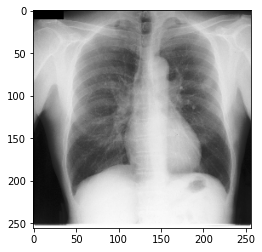

In [14]:
plt.imshow(images[0])
plt.show()

In [12]:
save_masks(masks)

In [15]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(images, masks)

In [16]:
print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

199 199
23 23
25 25


In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Build Model

In [17]:
class UNet():
    def __init__(self, input_size=(256,256,3), n_classes=5, drop=0.1):
        self.input_size = input_size
        self.n_classes = n_classes
        self.drop = drop
        
        self.model = self.create_model()
        
    
    def create_model(self):
        inputs = Input(self.input_size)
        
        # down sampling
        c1 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
        c1 = Dropout(self.drop)(c1)
        c1 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
        p1 = MaxPooling2D(2)(c1)
        
        c2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
        c2 = Dropout(self.drop)(c2)
        c2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
        p2 = MaxPooling2D(2)(c2)
        
        c3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        c3 = Dropout(self.drop)(c3)
        c3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
        p3 = MaxPooling2D(2)(c3)
        
        c4 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
        c4 = Dropout(self.drop)(c4)
        c4 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
        p4 = MaxPooling2D(2)(c4)
        
        c5 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
        c5 = Dropout(self.drop)(c5)
        c5 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)
        
        # up sampling
        u6 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
        c6 = Dropout(self.drop)(c6)
        c6 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
        
        u7 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
        c7 = Dropout(self.drop)(c7)
        c7 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
        
        u8 = Conv2DTranspose(32, 2, strides=(2,2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
        c8 = Dropout(self.drop)(c8)
        c8 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
        
        u9 = Conv2DTranspose(16, 2, strides=(2,2), padding='same')(c8)
        u9 = concatenate([u9, c1])
        c9 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
        c9 = Dropout(self.drop)(c9)
        c9 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
        
        outputs = Conv2D(self.n_classes, 1, activation='softmax')(c9)
        model = Model(inputs=[inputs], outputs=[outputs])
        
        return model

# Train Model

In [18]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

In [20]:
unet = UNet()
model = unet.model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [108]:
#tf.debugging.set_log_device_placement(False)

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(x_train, y_train,
                             batch_size=2,
                             epochs=6,
                             validation_data=(x_val, y_val),
                             shuffle=False)

Epoch 1/6


2022-03-27 10:02:14.637333: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


100/100 [==============================] - 13s 54ms/step - loss: 0.2893 - accuracy: 0.2252 - val_loss: 0.2141 - val_accuracy: 0.3013
Epoch 2/6
100/100 [==============================] - 3s 31ms/step - loss: 0.1594 - accuracy: 0.3842 - val_loss: 0.0941 - val_accuracy: 0.5316
Epoch 3/6
100/100 [==============================] - 3s 31ms/step - loss: 0.0683 - accuracy: 0.4853 - val_loss: 0.0485 - val_accuracy: 0.5379
Epoch 4/6
100/100 [==============================] - 3s 31ms/step - loss: 0.0512 - accuracy: 0.4859 - val_loss: 0.0616 - val_accuracy: 0.4324
Epoch 5/6
100/100 [==============================] - 3s 31ms/step - loss: 0.0380 - accuracy: 0.4846 - val_loss: 0.0339 - val_accuracy: 0.4660
Epoch 6/6
100/100 [==============================] - 3s 32ms/step - loss: 0.0294 - accuracy: 0.4860 - val_loss: 0.0256 - val_accuracy: 0.4966


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

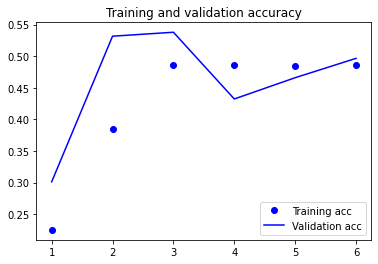

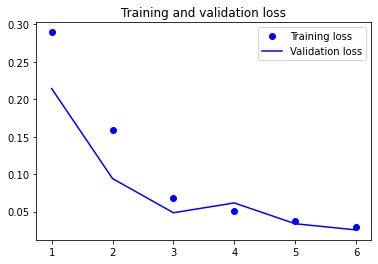

In [23]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
pred = model.predict(x_test)

In [27]:
pred_argmax = np.argmax(pred, axis=3)

In [28]:
print(pred_argmax.shape)
print(np.unique(pred_argmax))

(25, 256, 256)
[0 1 3 4]


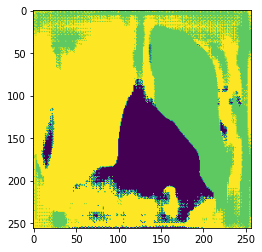

In [29]:
plt.imshow(pred_argmax[5])
plt.show()

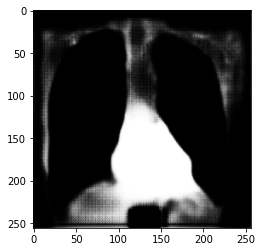

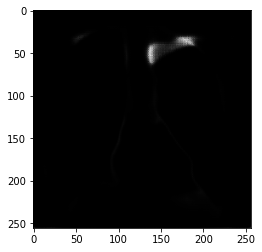

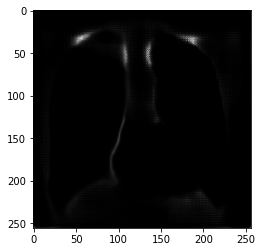

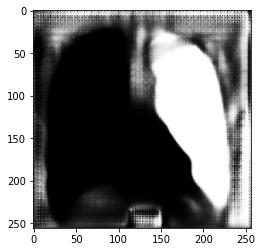

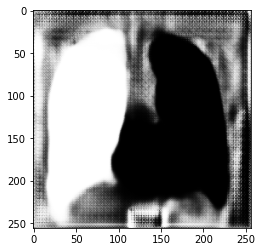

In [31]:
for i in range(5):
    plt.imshow(pred[0][:,:,i], cmap='gray')
    plt.show()

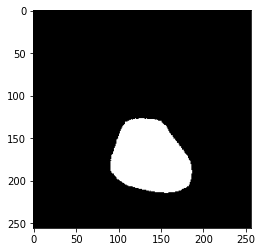

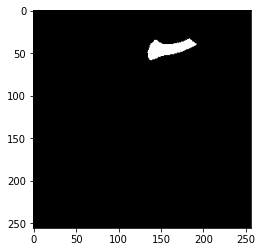

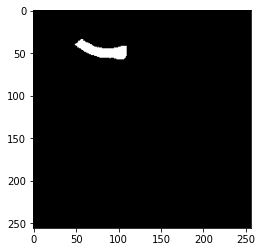

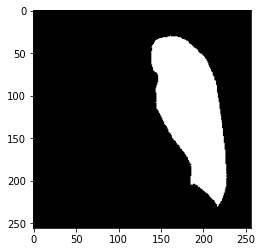

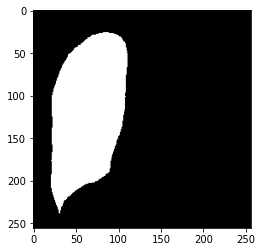

In [32]:
for i in range(5):
    plt.imshow(y_test[0][:,:,i], cmap='gray')
    plt.show()

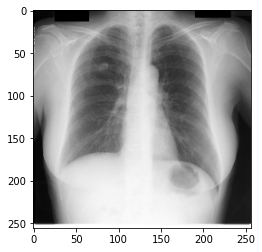

In [139]:
plt.imshow(images[5])
plt.show()

In [144]:
image_names = get_image_names()

In [145]:
home = os.path.expanduser('~')

In [146]:
img_path = os.path.join(home, 'Downloads/jsrt/images/images', image_names[0])

In [147]:
img_path

'/home/alphard/Downloads/jsrt/images/images/JPCLN001.png'

In [148]:
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

In [149]:
img.shape

(2048, 2048, 3)